# **Adaptive RAG**

Adaptive RAG is a strategy for RAG that uses query analysis to route questions to various RAG approaches based on their complexity.

We will borrow some ideas from the paper, shown in red (below):

- Perform query analysis to route questions

We will also build on some ideas from the Corrective RAG paper, shown in blue (below), and Self-RAG paper, shown in green:

- Route between our index (vectorstore) and web-search
- Evaluate retrieved documents for relevance to the user question
- Evaluate LLM generations for faithfulness to the documents (e.g., ensure no hallucinations)
- Evaluate LLM generations for usefulness to the question (e.g., does it answer the question)

We implement these ideas from scratch using llama and LangGraph:

- We use a graph to represent the control flow
- The graph state includes information (question, documents, etc) that we want to pass between nodes
- Each graph node modifies the state
- Each graph edge decides which node to visit next


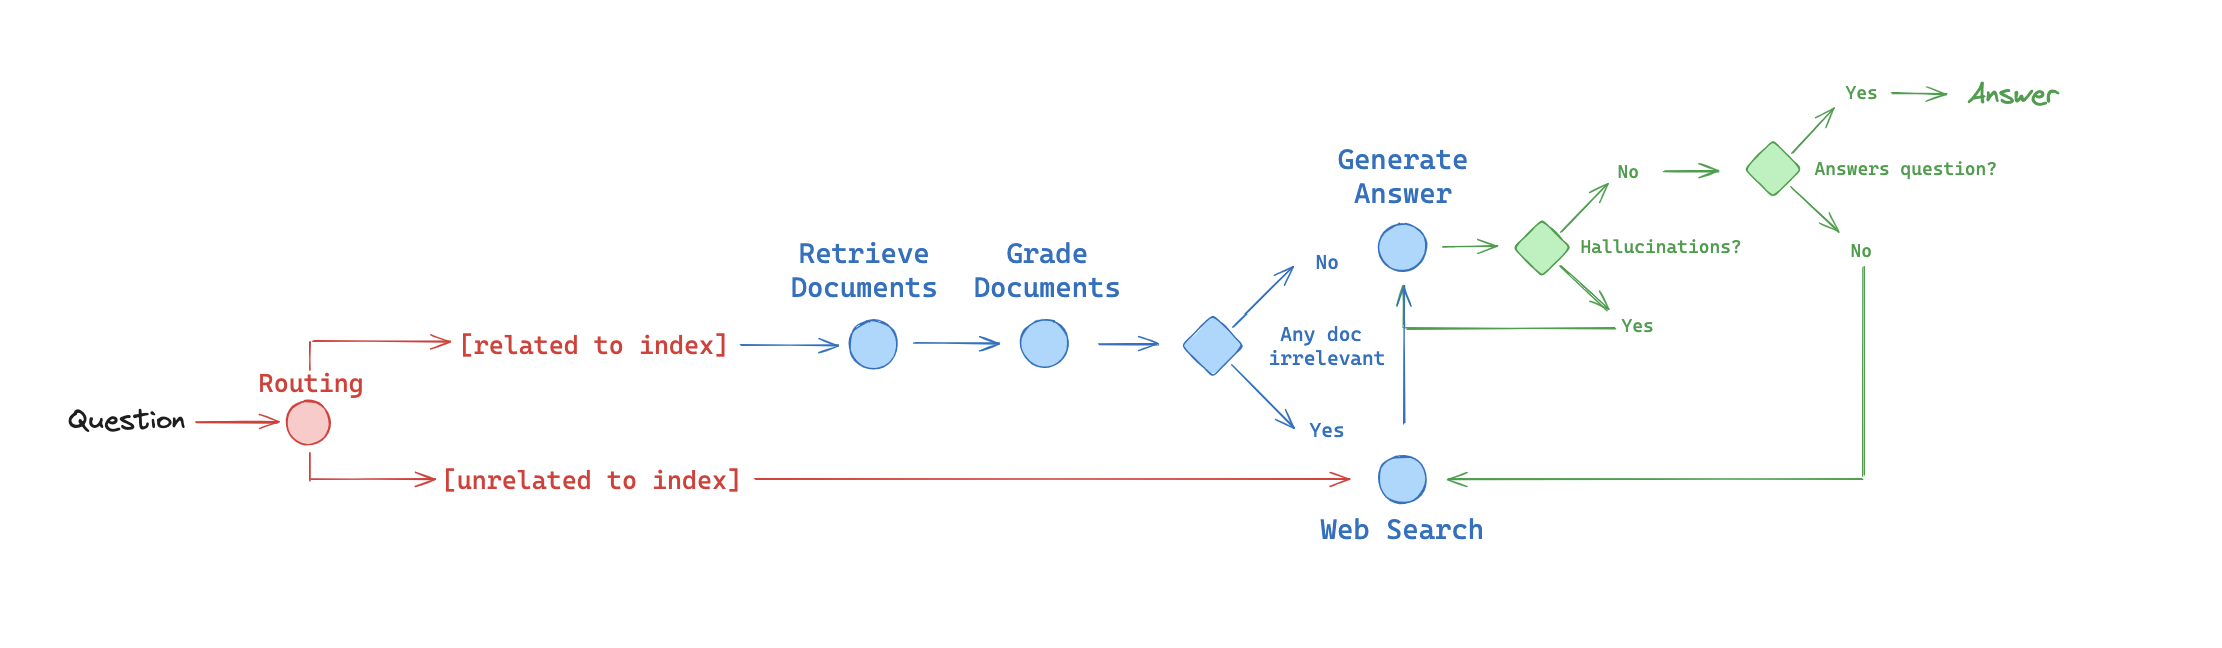

## **Setup**

**Load your API keys**

In [44]:
from dotenv import load_dotenv

load_dotenv()

True

## **LLM**

In [45]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

In [46]:
llm = ChatGroq(model="llama-3.1-70b-versatile")

## **Create an Index**

We will index 3 blog posts.

In [47]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

from langchain.embeddings import HuggingFaceBgeEmbeddings
import pickle

In [48]:
### Load the data (blog posts) ###

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]


### Split the data into chunks ###
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)


### Store in a vectorDB ###

# Load an existing (saved) embedding model from a pickle file
with open('embedding_model.pkl', 'rb') as f:
    embedding_model = pickle.load(f)


vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="arag-chroma",
    embedding=embedding_model,
)
retriever = vectorstore.as_retriever()

## **LLM Components**

### **Router Component**

In [49]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Data model
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource. """

    datasource: Literal["vectorstore", "websearch"] = Field(
        description="Given a user question choose to route it to websearch or a vectorstore.",
    )

# LLM with structured output
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
router_instructions = """You are an expert at routing a user question to a vectorstore or websearch.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
                                    
Use the vectorstore for questions on these topics. For all else, use web-search."""

In [50]:
# Test router
print(structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="Who will the Bears draft first in the NFL draft?")]))

print(structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="What are the types of agent memory?")]))

datasource='websearch'
datasource='vectorstore'


### **Retrieval Grader Component**

In [51]:
from langchain_core.prompts import ChatPromptTemplate

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with structured output
structured_llm_doc_grader = llm.with_structured_output(GradeDocuments)

# Doc grader system instructions 
doc_grader_system_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.

Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# user prompt
user_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

In [52]:
# Test
question = "agent memory"

docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content

user_prompt_formatted = user_prompt.format(document=doc_txt, question=question)

print(f"Formatted User Prompt: {user_prompt_formatted}")

print(structured_llm_doc_grader.invoke([SystemMessage(content=doc_grader_system_instructions)] + [HumanMessage(content=user_prompt)]))

Formatted User Prompt: Here is the retrieved document: 

 Reflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)

Prompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.


Planning & Reacting: translate the reflections and the environment information into actions

Planning is essentially in order to optimize believability at the moment vs in time.
Prompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)
Relationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.
Environment information is present in a tree structure.




Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)


### **Generate Component**

In [53]:
from langchain_core.output_parsers import StrOutputParser

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Use the following pieces of retrieved context to answer the question. 

If you don't know the answer, just say that you don't know. 

Use three sentences maximum and keep the answer concise.

Question: {question} 

Context: {context} 

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Test
question = "What is Chain of thought prompting?"
docs = retriever.get_relevant_documents(question)
docs_txt = format_docs(docs)

rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Chain of thought (CoT) prompting is a technique that involves instructing a model to "think step by step" to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. It transforms big tasks into multiple manageable tasks and provides insight into the model's thinking process.


### **Hallucination Grader Component**

In [54]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")
    explanation: str = Field(description="Explain the reasoning for the score")

# LLM with function call 
structured_llm_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# Hallucination grader system instructions 
hallucination_grader_system_instructions = """You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = "FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}"

In [55]:
# Test using documents and generation from above 
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation)
score = structured_llm_hallucination_grader.invoke([SystemMessage(content=hallucination_grader_system_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
print(f"Score: {score.binary_score}\n\nExplanation: {score.explanation}")

Score: yes

Explanation: The student answer is grounded in the facts and does not contain hallucinated information outside the scope of the facts. The student answer is a direct paraphrase of the information provided in the facts, specifically the section on Chain of Thought (CoT; Wei et al. 2022). The student answer accurately describes the CoT prompting technique and its purpose, without introducing any new or unrelated information.


### **Answer Grader Component**

In [56]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")
    explanation: str = Field(description="Explain the reasoning for the score")

# LLM with function call 
structured_llm_answer_grader = llm.with_structured_output(GradeAnswer)

# Answer grader system instructions 
answer_grader_system_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION

(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = "QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}"

In [57]:
# Test using question and generation from above 
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation)

score = structured_llm_answer_grader.invoke([SystemMessage(content=answer_grader_system_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])

print(f"Score: {score.binary_score}\n\nExplanation: {score.explanation}")

Score: yes

Explanation: The student answer addresses the question by providing a clear definition of Chain of thought prompting, explaining that it is a technique that involves instructing a model to 'think step by step' and decompose hard tasks into smaller and simpler steps. The student's answer is concise and relevant to the question, providing insight into the model's thinking process. Therefore, the student's answer meets all the criteria, resulting in a 'yes' score.


## **Web Search Tool**

In [58]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## **Graph**

We will build the above workflow as a graph using **LangGraph**.

### **Graph state**

The graph state schema contains keys that we want to:

- Pass to each node in our graph
- Optionally, modify in each node of our graph

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

In [59]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

Each `node` in our graph is simply a function that:

1. Take state as an input

2. Modifies state

3. Write the modified state to the state schema (dict)

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes).

Each edge routes between nodes in the graph.

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges).

### **Nodes**

In [60]:
from langchain.schema import Document
from langgraph.graph import END

In [61]:
### Retrieve Node ###

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}


### Generate Node ###

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    
    return {"generation": generation, "loop_step": loop_step + 1}


### Grade Document Node ###

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    
    for doc in documents:
        doc_grader_prompt_formatted = user_prompt.format(
            document=doc.page_content, question=question
        )

        score = structured_llm_doc_grader.invoke(
            [SystemMessage(content=doc_grader_system_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = score.binary_score

        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)

        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue

    return {"documents": filtered_docs, "web_search": web_search}



### Web Search Node ###

def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in docs])
    web_results = Document(page_content=web_results)

    documents.append(web_results)
    
    return {"documents": documents}

### **Edges**

In [62]:
### Question Router Edge ###

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    source = structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])]) 
    
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


### Generation Decision Edge ###

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    

### Generation wrt Document and Question Grader Edge ###

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    answer_document_score = structured_llm_hallucination_grader.invoke([SystemMessage(content=hallucination_grader_system_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    answer_document_grade = answer_document_score.binary_score

    # Check hallucination
    if answer_document_grade.lower() == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        
        # Test using question and generation from above 
        answer_question_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        answer_question_score = structured_llm_answer_grader.invoke([SystemMessage(content=answer_grader_system_instructions)] + [HumanMessage(content=answer_question_grader_prompt_formatted)])
        answer_question_grade = answer_question_score.binary_score

        if answer_question_grade.lower() == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        
        elif answer_question_grade.lower() == "no":
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        
        elif state["loop_step"] > max_retries:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
        
    elif answer_document_grade.lower() == "no":
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    
    elif state["loop_step"] > max_retries:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

### **Control Flow**

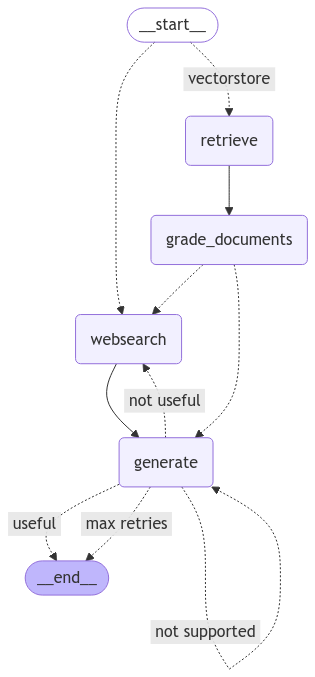

In [63]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
graph_input = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and s

In [65]:
graph_input = {"question": "Who is the top candidate in the 2025 NFL draft?"}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'Who is the top candidate in the 2025 NFL draft?', 'loop_step': 0}
---WEB SEARCH---
{'question': 'Who is the top candidate in the 2025 NFL draft?', 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Here is an updated look at the top 100 prospects eligible for the 2025 NFL Draft. Updated Top 100 for 2025 NFL Draft Updated 2025 NFL Draft Top 10 1. Travis Hunter, WR/DB, Colorado 2. Will Johnson\nRanking top 10 candidates to go No. 1 overall in 2025 NFL Draft: Shedeur Sanders, Carson Beck best QB options Who in the world is going to be the No. 1 overall pick in the 2025 NFL Draft? With Allar, who\'s only 20 years old, it\'s always been about his tremendous, No. 1 overall pick upside, which he demonstrated at times in 2023 -- even if there are raw edges to his game. There were some accuracy mishaps sprinkled throughout his breakout 2023 campaign for the Longhorns, so if he plays with more passing precision 